### Simple 1D Richards' Equation Model

This is a 1D Richards' equation model, written by Andrew Ireson, 3 November 2015.


In [1]:
# Import all of the basic libraries (you will always need these)
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
plt.style.use('ggplot')

# Import a library that contains soil moisture properties and functions
import vanGenuchten as vg

# Import ODE solvers
from scipy.interpolate import interp1d
from scipy.integrate import odeint

# Select which soil properties to use
p=vg.HygieneSandstone()
p = vg.BeitNetofaClay()
#p = vg.GuelphLoamDrying()

In [2]:
# Richards equation solver
# This is a function that calculated the right hand side of Richards' equation. You
# will not need to modify this function, unless you are doing something advanced. 
# This block of code must be executed so that the function can be later called.

def RichardsModel(psi,t,dz,n,p,vg,qTop,qBot,psiTop,psiBot):
       
    # Basic properties:
    C=vg.CFun(psi,p)
   
    # initialize vectors:
    q=np.zeros(n+1)
    
    # Upper boundary
    if qTop == []:
        KTop=vg.KFun(np.zeros(1)+psiTop,p)
        q[n]=-KTop*((psiTop-psi[n-1])/dz*2+1)
    else:
        q[n]=qTop
    
    # Lower boundary
    if qBot == []:
        if psiBot == []:
            # Free drainage
            KBot=vg.KFun(np.zeros(1)+psi[0],p)
            q[0]=-KBot
        else:
            # Type 1 boundary
            KBot=vg.KFun(np.zeros(1)+psiBot,p)
            q[0]=-KBot*((psi[0]-psiBot)/dz*2+1.0)    
    else:
        # Type 2 boundary
        q[0]=qBot

    # Internal nodes
    i=np.arange(0,n-1)
    Knodes=vg.KFun(psi,p)
    Kmid=(Knodes[i+1]+Knodes[i])/2.0
    
    j=np.arange(1,n)
    q[j]=-Kmid*((psi[i+1]-psi[i])/dz+1.0)
    
    
    # Continuity
    i=np.arange(0,n)
    dpsidt=(-(q[i+1]-q[i])/dz)/C
    
    return dpsidt

-  $C(h)$ [1/L] is a function describing the rate of change of saturation with respect the matric head:
- $ C(h)\equiv {\frac {\partial \theta }{\partial h}}$  
- 'specific moisture capacity'.
-  can be determined for different soil types using curve fitting and laboratory experiments measuring the rate of infiltration of water into soil column, as described for example in van Genuchten (1980)
   

In [3]:
psi = np.linspace(-10,0)
theta = vg.thetaFun(psi,p)
C=vg.CFun(psi,p)
K=vg.KFun(psi,p)


In [4]:
def thetaFun(psi,pars):
    if psi>=0.:
        Se = 1.
    else:
        Se=(1+abs(psi*pars['alpha'])**pars['n'])**(-pars['m'])
    return pars['thetaR']+(pars['thetaS']-pars['thetaR'])*Se


$$m = 1 - 1/n$$
$$n\cdot m  = n-1$$

$$n  = 1/(1-m) $$



$$ \Theta = [ 1 + ( \alpha \ h )^n ] ^{-m} $$

_Equation 21_
$$ \theta = \theta_R+ \frac{(\theta_S - \theta_R )}{[ 1 + ( \alpha \ h )^n ] ^m }  $$


_Equation 23_
$$ \frac{d \Theta}{dh}=\alpha \cdot \frac{m}{1-m} \cdot \Theta ^{1/m} \cdot (1-\Theta^{1/m})^m$$
$$ \frac{d \theta}{dh}=\alpha \cdot (\theta_S -\theta_R) \cdot \frac{m}{1-m} \cdot \Theta ^{1/m} \cdot (1-\Theta^{1/m})^m$$

$$ C = \Theta \cdot S_s+ \frac{d \theta }{dh}$$


_ Equation 8_
$$ K = K_s \Theta^{1/2} \cdot (1-(1-\Theta^{1/m})^m)^2$$ 

This code is set up with $ ∂h/∂z = 1$


In [5]:
def CFun1(psi,pars):
    if psi>=0.:
        Se=1.
    else:
        Se=(1+abs(psi*pars['alpha'])**pars['n'])**(-pars['m'])
    dSedh=pars['alpha']*pars['m']/(1-pars['m'])*Se**(1/pars['m'])*(1-Se**(1/pars['m']))**pars['m']
    return Se*pars['Ss']  

CFun1 = np.vectorize(CFun1) 

def CFun2(psi,pars):
    if psi>=0.:
        Se=1.
    else:
        Se=(1+abs(psi*pars['alpha'])**pars['n'])**(-pars['m'])
    dSedh=pars['alpha']*pars['m']/(1-pars['m'])*Se**(1/pars['m'])*(1-Se**(1/pars['m']))**pars['m']
    return (pars['thetaS']-pars['thetaR'])*dSedh


CFun2 = np.vectorize(CFun2)

def CFun(psi,pars):
    if psi>=0.:
        Se=1.
    else:
        Se=(1+abs(psi*pars['alpha'])**pars['n'])**(-pars['m'])
    dSedh=pars['alpha']*pars['m']/(1-pars['m'])*Se**(1/pars['m'])*(1-Se**(1/pars['m']))**pars['m']
    return Se*pars['Ss']+(pars['thetaS']-pars['thetaR'])*dSedh

CFun = np.vectorize(CFun)

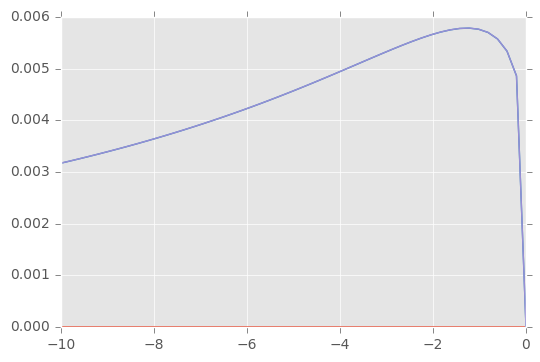

In [6]:
plt.plot(psi, CFun1(psi, p))
plt.plot(psi, CFun2(psi, p))
plt.plot(psi, CFun(psi, p))

In [7]:
def KFun(psi,pars):
    if psi>=0.:
        Se=1.
    else:
        Se=(1+abs(psi*pars['alpha'])**pars['n'])**(-pars['m'])
    return pars['Ks']*Se**pars['neta']*(1-(1-Se**(1/pars['m']))**pars['m'])**2

KFun = np.vectorize(KFun)


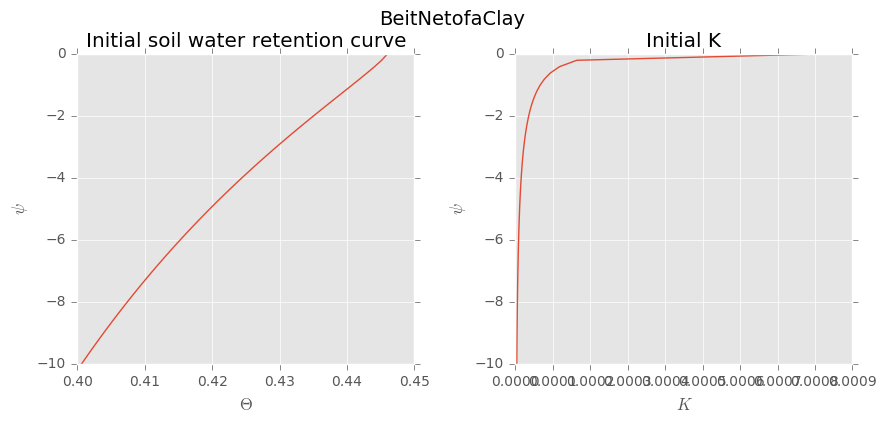

In [8]:
plt.figure(figsize = (10, 4))
plt.subplots_adjust(wspace = .3)
plt.subplot(121)
plt.plot( theta, psi)
plt.xlabel("$ \Theta $")
plt.ylabel("$\psi$")
plt.title("Initial soil water retention curve")

plt.subplot(122)
plt.plot( K, psi)
plt.ylabel("$\psi$")
plt.xlabel("$K$")
plt.title("Initial K")

t = plt.suptitle(p['name'], fontsize = 14); t.set_y(1.01)

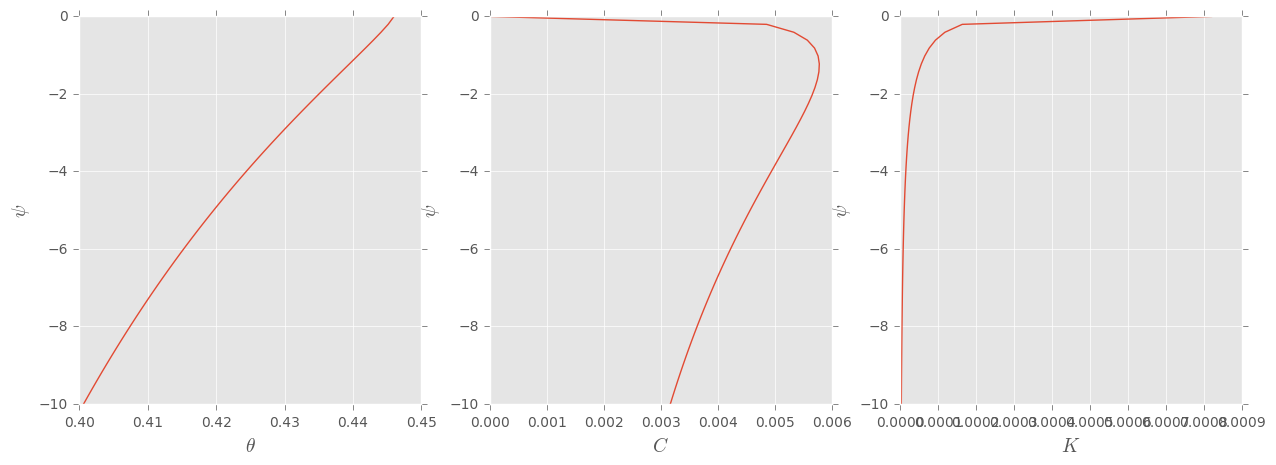

In [9]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.subplots_adjust(hspace = .4)
plt.subplot(131)
plt.plot(theta, psi)
plt.ylabel(r'$\psi$', fontsize=14)
plt.xlabel(r'$\theta$', fontsize=14)
plt.subplot(132)
plt.plot(C, psi)
plt.ylabel(r'$\psi$', fontsize=14)
plt.xlabel(r'$C$',fontsize=14)
plt.subplot(133)
plt.plot(K, psi)
plt.xlabel(r'$K$', fontsize=14)
plt.ylabel(r'$\psi$', fontsize=14)


In [ ]:
# This block of code sets up and runs the model

# Boundary conditions
qTop= -0.01
qBot= []
psiTop= []
psiBot= []

# Grid in space
dz=0.1
ProfileDepth=5
z=np.arange(dz/2.0,ProfileDepth,dz)
n=z.size

# Grid in time
t = np.linspace(0,10,101)

# Initial conditions
psi0=-z

# Solve
psi=odeint(RichardsModel,psi0,t,args=(dz,n,p,vg,qTop,qBot,psiTop,psiBot),mxstep=5000000);
#print "Model run successfully"    

In [ ]:
# Post process model output to get useful information

# Get water content
theta=vg.thetaFun(psi,p)

# Get total profile storage
S=theta.sum(axis=1)*dz

# Get change in storage [dVol]
dS=np.zeros(S.size)
dS[1:]=np.diff(S)/(t[1]-t[0])

# Get infiltration flux
if qTop == []:
    KTop=vg.KFun(np.zeros(1)+psiTop,p)
    qI=-KTop*((psiTop-psi[:,n-1])/dz*2+1)
else:
    qI=np.zeros(t.size)+qTop
    
# Get discharge flux
if qBot == []:
    if psiBot == []:
        # Free drainage
        KBot=vg.KFun(psi[:,0],p)
        qD=-KBot
    else:
        # Type 1 boundary
        KBot=vg.KFun(np.zeros(1)+psiBot,p)
        qD=-KBot*((psi[:,0]-psiBot)/dz*2+1.0)
else:
    qD=np.zeros(t.size)+qBot
    

In [ ]:
# Plot vertical profiles
plt.rcParams['figure.figsize'] = (10.0, 10.0)
for i in range(0,t.size-1):
    plt.subplot(121)
    plt.plot(psi[i,:],z)
    plt.subplot(122)
    plt.plot(theta[i,:],z)

plt.subplot(121)
plt.ylabel('Elevation [m]',fontsize=20)
plt.xlabel(r'$\psi$ [m]',fontsize=20)
plt.subplot(122)
plt.xlabel(r'$\theta$ [-]',fontsize=20)

In [ ]:
# Plot timeseries
dt = t[2]-t[1]
pl.plot(t,dS,label='Change in storage')
pl.hold(True)
pl.plot(t,-qI,label='Infiltration')
pl.plot(t,-qD,label='Discharge')
pl.legend(loc="upper left")
pl.ylim((0,0.02))